In [34]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_parallel"): print("\nThe data folder \"_data_parallel\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_parallel/"); 
    path_data = path_notebook + "/_data_parallel/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 50, 50, 50, 70, 60, 60, 70, 80, 80, 90, 80, 90, 80, 100, 100, 100, 110, 110]
    n_surf = 3
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    # plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_parallel/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


In [40]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

## Analytical surface

In [36]:
# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 50, 50, 50, 70, 60, 60, 70, 80, 80, 90, 80, 90, 80, 100, 100, 100, 110, 110]
    n_surf = 3
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    # plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


In [37]:
# Stimulation path
path_simulation = path_data + "test/"

# Select surface
n_surf = 3
y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"

# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "simulation_steps": 1_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":5, "biasfactor":50 , 
					"len_error_list":100, "FES_cutoff":FES_cutoff, "record_forces_e":True,
     				"simulation_folder_path": path_simulation, "print_info": True}

### Example simulation

Analysing simulation 0 / 4
| 100% | AAD: 0.543 [kJ/mol] | Total time: 1 sec                                                            
Analysing simulation 1 / 4
Analysing simulation 2 / 4
Analysing simulation 3 / 4
All simulations analysed
Patching simulations


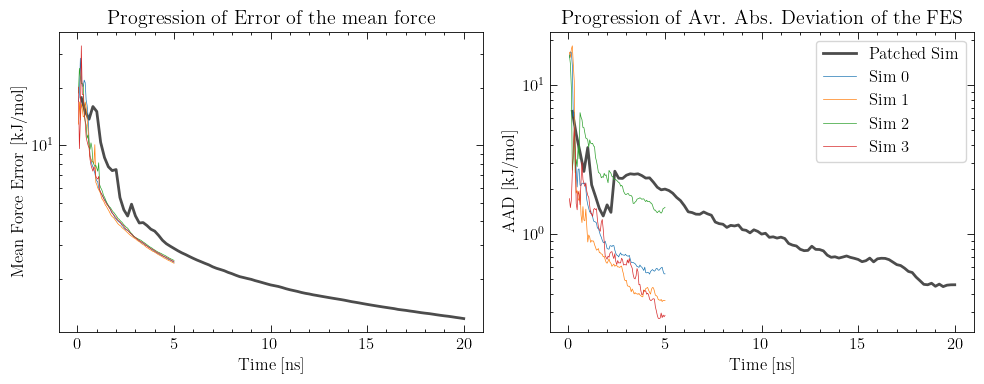

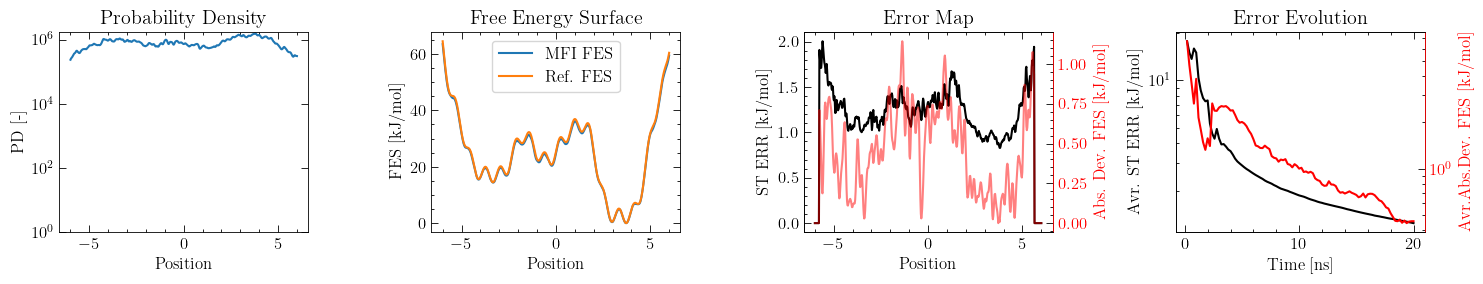

In [41]:
## Load MFI object
MFI = MFI_class1D.MFI1D(**default_params)

## prepare parallel simulations set-up
workers = 4
i_start = 0
simulation_folder_path_list = [path_simulation + f"simulation_{i}" for i in range(i_start, i_start+workers)]

## Create parallel MFI object
mfi_p = MFI.MFI_parallel(parent=MFI, workers=workers, simulation_folder_path_list=simulation_folder_path_list) 

## Run parallel simulations
# mfi_p.run_parallel_sim()

## Analyse simulations
mfi_p.analyse_parallel()

## Patch simulations
mfi_p.patch_simulations()

## Plot results
mfi_p.plot_parallel_results()
MFI.plot_results()


### Run Multiple Long Simulations and analysis (for statistical analysis)

In [48]:
# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 5_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":5, "biasfactor":50 , 
					"len_error_list":100, "FES_cutoff":FES_cutoff, "simulation_folder_path": path_simulation, "print_info": True}

In [4]:

# Loop over all surfaces
# for n_surf in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
# for n_surf in range(20):
for n_surf in [4]:
    y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    print(f"\n~~~~~~ Surface {n_surf} ~~~~~~")

    # loop over simulations
    for i in range(1,17):
        
        print(f"~~~~~~ Simulation {i} ~~~~~~")
        
        new_path = path_data + f"S{n_surf}/simulation_{i}/"
        ext = f"_surf{n_surf}_{i}_2p5ns"      
          
        #check if directory exists
        if os.path.isdir(new_path): pass
        else: os.mkdir(new_path)
        os.chdir(new_path)
        
        new_params = default_params.copy()
        new_params.update({"simulation_folder_path":new_path, "file_extension":ext})
        new_params.update({"y":y, "plumed_dat_text":plumed_dat_text, "FES_cutoff":FES_cutoff})

        ## Load MFI object
        MFI = MFI_class1D.MFI1D(**new_params)

        # ## check if HILLS file exists
        if os.path.isfile(MFI.hills_file): print("HILLS file exists, skipping simulation")
        else: MFI.run_simulation()
            
        if os.path.isfile(f"MFI_results{ext}.pkl"): print("Data file exists, skipping analysis")
        else:
            MFI.analyse_data()
            MFI.plot_results()

In [12]:
# path_longx4 = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/"
# os.chdir(path_longx4)
# MFI = MFI_1D_class.MFI1D_class(y_string=y_string, simulation_steps=5_000_000, pl_grid=pl_x, bw=dx*1.5, y=y, dy=dy, grid=grid, FES_cutoff=50, 
#                                          metad_width=0.1, metad_height=5, biasfactor=10, metad_pace=500, position_pace=50, start_sim=True,show_progress=True)

# simulation_folder_path_list, save_data_path_list, initial_position_list = [], [], []
# workers = 4
# i_start = 50
# for i in range(i_start, i_start+workers):
# 	simulation_folder_path_list.append(path_longx4 + f"simulation_{i}"  )
# 	save_data_path_list.append(path_longx4 + f"/simulation_{i}/MFI_data{i}_20M.pkl")
# 	initial_position_list.append(None)
 
# mfi_p = MFI.MFI_parallel(parent=MFI, workers=workers, simulation_folder_path_list=simulation_folder_path_list, save_data_path_list=save_data_path_list, initial_position_list=initial_position_list) 



# # mfi_p.run_parallel_sim()

# mfi_p.analyse_parallel()

# mfi_p.patch_simulations()

# mfi_p.plot_parallel_results()

# MFI.plot_results()


In [13]:
# sim_f_path = f"/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/"
# MFI_c1 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start}")
# MFI_c1.analyse_data()

# MFI_c2 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, base_forces=MFI_c1.force_terms, base_time=MFI_c1.Avr_Error_list[-1][0], show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start+1}")
# MFI_c2.analyse_data()
# base = lib1.patch_forces(MFI_c1.force_terms, MFI_c2.force_terms)

# MFI_c3 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, base_forces=base, base_time=MFI_c2.Avr_Error_list[-1][0], show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start+2}")
# MFI_c3.analyse_data()
# base = lib1.patch_forces(base, MFI_c3.force_terms)

# MFI_c4 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, base_forces=base, base_time=MFI_c3.Avr_Error_list[-1][0], show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start+3}")
# MFI_c4.analyse_data()



# plt.plot(np.array(MFI_c1.Avr_Error_list)[:,0], np.array(MFI_c1.Avr_Error_list)[:,4], label="1")
# plt.plot(np.array(MFI_c2.Avr_Error_list)[:,0], np.array(MFI_c2.Avr_Error_list)[:,4], label="2")
# plt.plot(np.array(MFI_c3.Avr_Error_list)[:,0], np.array(MFI_c3.Avr_Error_list)[:,4], label="3")
# plt.plot(np.array(MFI_c4.Avr_Error_list)[:,0], np.array(MFI_c4.Avr_Error_list)[:,4], label="4")
# plt.plot(np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,4], label="Patched in time", color="grey", alpha=0.3, linewidth=3)


# plt.yscale("log")
# plt.legend(); plt.show()

# # MFI_c1.plot_results()
# # MFI_c2.plot_results()
# # MFI_c3.plot_results()
# # MFI_c4.plot_results()

#### Patch and Find error progression. 

In [1]:
# simulation_path = "/home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/"
# os.chdir(simulation_path)

# # @njit
# def patch_and_error_prog_n_sim(grid, force_terms_collection, y=None, PD_cutoff=1, FES_cutoff=None, use_ST_ERR=True, use_VNORM=False):
    
#     # force_terms_collection = np.array(force_terms_collection, dtype=float)
#     assert len(np.shape(force_terms_collection)) == 4, "force_terms_collection must be a 4D array with dimensions (n_sim, n_iter, 4_force_terms, nbins)"
    
#     n_sim = np.shape(force_terms_collection)[0]
#     n_iter = np.shape(force_terms_collection)[1]
#     nbins = np.shape(force_terms_collection)[3]
#     dx = grid[1] - grid[0]
    
#     PD = np.zeros(nbins)
#     PD2 = np.zeros(nbins)
#     Force_num = np.zeros(nbins)
#     ofv_num = np.zeros(nbins)
    
#     ofe_prog = []
#     aad_prog = []
    
#     for i in range(n_iter):
        
#         for j in range(n_sim):
            
#             PD += force_terms_collection[j, i, 0, :]
#             PD2 += force_terms_collection[j, i, 1, :]
#             Force_num += force_terms_collection[j, i, 2, :] * force_terms_collection[j, i, 0, :]
#             ofv_num += force_terms_collection[j, i, 3, :]
            
#         Force = np.divide(Force_num, PD, out=np.zeros_like(Force_num), where=PD>1E-10)
#         # Force = np.where(PD > 1E-10, Force_num / PD, 0.0)
#         FES = lib1.intg_1D(Force, dx)
        
#         # Find cutoff
#         cutoff = np.ones(nbins, dtype=np.float64)
#         if FES_cutoff is not None: cutoff = np.where(FES > FES_cutoff, 0.0, 1.0) #if FES_cutoff is not None else np.ones(nbins)#, dtype=np.float64)
#         if PD_cutoff is not None and PD_cutoff > 0: cutoff = np.where(PD < PD_cutoff, 0.0, cutoff)
#         space_explored = np.sum(cutoff)      
#         ratio_explored = space_explored / nbins

#         # Find error of the mean force
#         ofv = np.divide(ofv_num, PD, out=np.zeros_like(ofv_num), where=(PD>1E-10) & (cutoff > 0.5)) - np.square(Force)
#         # ofv = np.where((PD > 1E-10) & (cutoff > 0.5), ofv_num / PD, 0.0)  
#         Bessel_corr_num = PD2.copy() if use_ST_ERR == True else np.square(PD)
#         ofv *= np.divide(Bessel_corr_num, np.square(PD) - PD2, out=np.zeros_like(Bessel_corr_num), where=((np.square(PD) - PD2 > 0) & (cutoff > 0.5)))
#         # ofv *= np.where((np.square(PD) - PD2 > 0) & (cutoff > 0.5), Bessel_corr_num / (np.square(PD) - PD2), 0.0)
#         ofe = np.sqrt(ofv*cutoff)
#         Aofe = np.sum(ofe) / space_explored if space_explored > 0 else np.nan
#         if use_VNORM: Aofe = Aofe * space_explored / nbins
        
#         if y is not None:
#             AD = np.absolute(FES - y) * cutoff
#             AAD = np.sum(AD) / space_explored if space_explored > 0 else np.nan
#             if use_VNORM: AAD = AAD * space_explored / nbins

#         ofe_prog.append(Aofe)
#         aad_prog.append(AAD)
        
#     return ofe_prog, aad_prog
    

# force_terms_collection, time = [], []

# sim_index = [1,2,3,4]
# # for ii in range(1,5):
# for ii in sim_index:
	
# 	new_path = simulation_path + "simulation_" + str(ii) + "/"
# 	os.chdir(new_path)
	
# 	force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{ii}_20M.pkl")
# 	force_terms_collection.append(forces_e_list)
# 	time.append(np.array(Avr_Error_list)[:,0])
	
# ofe_prog, aad_prog = patch_and_error_prog_n_sim(grid, np.array(force_terms_collection), y=y, PD_cutoff=1, FES_cutoff=50, use_ST_ERR=True, use_VNORM=False)  
# time = np.sum(time, axis=0)

# print(f"AOFE: {ofe_prog[-1]},  AAD: {aad_prog[-1]}")

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(time, ofe_prog, color="red", label=f"Patched Sim {sim_index}")
# plt.title("Progression of Error of the mean force"); plt.xlabel("Time [ns]"); plt.ylabel("Mean Force Error [kJ/mol]"); plt.yscale("log")

# plt.subplot(1,2,2)
# plt.plot(time, aad_prog, color="red", label=f"Patched Sim {sim_index}")
# plt.title("Progression of Avr. Abs. Deviation of the FES"); plt.xlabel("Time [ns]"); plt.ylabel("AAD [kJ/mol]"); plt.yscale("log")


# for ii in sim_index:
    
# 	new_path = simulation_path + "simulation_" + str(ii) + "/"
# 	os.chdir(new_path)
# 	force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{ii}_20M.pkl")

# 	plt.subplot(1,2,1)
# 	plt.plot(np.array(Avr_Error_list)[:,0], np.array(Avr_Error_list)[:,2], label=f"Simulation {ii}", alpha=0.5, linewidth=0.5, color="red")
# 	plt.subplot(1,2,2)
# 	plt.plot(np.array(Avr_Error_list)[:,0], np.array(Avr_Error_list)[:,4], label=f"Simulation {ii}", alpha=0.5, linewidth=0.5, color="red")



# plt.legend()
# plt.tight_layout(); plt.show()


# print(len(aad_prog))


In [3]:
# simulation_path = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/"
# os.chdir(simulation_path)

# err_collection = []
# aad_collection = []

# for i in range(25):
       
#     force_terms_collection, time = [], []
    
#     for ii in range(i*4 + 1, (i+1)*4+1):
        
#         new_path = simulation_path + "simulation_" + str(ii) + "/"
#         os.chdir(new_path)
        
#         force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{ii}_20M.pkl")
#         force_terms_collection.append(forces_e_list)
#         time.append(np.array(Avr_Error_list)[:,0])
        
#     ofe_prog, aad_prog = patch_and_error_prog_n_sim(grid, force_terms_collection, y=y, PD_cutoff=1, FES_cutoff=50, use_ST_ERR=True, use_VNORM=False)  
#     err_collection.append(ofe_prog)
#     aad_collection.append(aad_prog)
#     time = np.sum(time, axis=0)
    


# [time, ofe_mean, ofe_ste, aad_mean, aad_ste] = lib1.get_mean_ste_of_n_error_prog(time, err_collection, aad_collection, plot=False, plot_log=True, plot_title=["Error of Mean Force", "AAD of FES"], plot_xlabel=["Time"], plot_ylabel=["Error [kJ/mol]","AAD [kJ/mol]"])

# print(f"AOFE: {ofe_mean[-1]},  AAD: {aad_mean[-1]}")

# for i in range(len(err_collection)):         
    
#     plt.subplot(1,2,1)
#     plt.plot(time, err_collection[i], linewidth=0.5, alpha=0.2, color="black")
    
#     plt.subplot(1,2,2)
#     plt.plot(time, aad_collection[i], linewidth=0.5, alpha=0.2, color="black")    
    
# plt.tight_layout(); plt.show()
    




#### Get Mean and ST ERR of Error Progression

In [29]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [4]:
# simulation_path = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_long/"
# os.chdir(simulation_path)

# err_collection = []
# aad_collection = []
# plt.figure(figsize=(10,10))

# for i in range(1,21):
        
#     new_path = simulation_path + "simulation_" + str(i) + "/"
#     os.chdir(new_path)
    
#     force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{i}_20M.pkl")
#     err_collection.append(Avr_Error_list[:,2])
#     aad_collection.append(Avr_Error_list[:,4])


# lib1.get_mean_ste_of_n_error_prog(Avr_Error_list[:,0], err_collection, aad_collection, plot_log=False, plot_title=["Error of Mean Force", "AAD of FES"], plot_xlabel=["Time"], plot_ylabel=["Error [kJ/mol]","AAD [kJ/mol]"])


In [5]:
# simulation_path = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_long/"
# os.chdir(simulation_path)

# err_collection = []
# aad_collection = []
# plt.figure(figsize=(10,10))

# for i in range(1,21):
        
#     new_path = simulation_path + "simulation_" + str(i) + "/"
#     os.chdir(new_path)
    
#     force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{i}_20M.pkl")
#     err_collection.append(Avr_Error_list[:,2])
#     aad_collection.append(Avr_Error_list[:,4])
#     # plt.plot(Avr_Error_list[:,0], Avr_Error_list[:,4], linewidth=0.5, alpha=0.2, color="red")


# lib1.get_mean_ste_of_n_error_prog(Avr_Error_list[:,0], err_collection, aad_collection, plot=False, plot_log=True, plot_title=["Error of Mean Force", "AAD of FES"], plot_xlabel=["Time"], plot_ylabel=["Error [kJ/mol]","AAD [kJ/mol]"])


# for i in range(1,21):
        
#     new_path = simulation_path + "simulation_" + str(i) + "/"
#     os.chdir(new_path)
    
#     force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{i}_20M.pkl")
#     plt.subplot(1,2,1)
#     plt.plot(Avr_Error_list[:,0], Avr_Error_list[:,2], linewidth=0.5, alpha=0.2, color="black")
#     plt.subplot(1,2,2)
#     plt.plot(Avr_Error_list[:,0], Avr_Error_list[:,4], linewidth=0.5, alpha=0.2, color="black")

# plt.show()
    

### Surface 14

In [6]:
# path_class = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/"
# os.chdir(path_class)

# n_surf = 14
# [grid, y_list, y_string_list] = lib1.load_pkl("fes_list_new")
# y = y_list[n_surf]
# dy = np.gradient(y, grid[1] - grid[0])
# y_string = y_string_list[n_surf]  
# dx = grid[1] - grid[0]  

# ### Find plumed grid (such that the mfi grid is a subset of the plumed grid)
# [pl_x, pl_min, pl_max, pl_n, pl_ext] = run_sim_lib.get_plumed_grid_1D(grid, -7, 7, print_info=True)

# path_simulation = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/S14/"
# os.chdir(path_simulation)

# print(y_string); plt.plot(grid, y); plt.title(f"Surface {n_surf}"); plt.xlabel("CV"); plt.ylabel("FES [kJ/mol]"); plt.show()

#### Run and analyse data

In [7]:
# simulation_path = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/S14/"
# os.chdir(simulation_path)

# for i in range(1,40):
    
#     print(f"~~~~~~ Simulation {i} ~~~~~~")
    
#     new_path = simulation_path + "simulation_" + str(i) + "/"
    
#     #check if directory exists
#     if os.path.isdir(new_path): pass
#     else: os.mkdir(new_path)
#     os.chdir(new_path)
    
#     ## Load MFI object
#     ipos = lib1.get_random_move(grid[0], grid[-1])        
#     MFI = MFI_1D_class.MFI1D_class(y_string=y_string, simulation_steps=5_000_000, initial_position=None, pl_grid=pl_x,
#                                         metad_width=0.1, metad_height=5, biasfactor=50, metad_pace=500, position_pace=50, start_sim=True,
#                                         bw=dx*1.5, y=y, dy=dy, grid=grid, show_progress=True,
#                                         hills_file="HILLS", position_file="position", save_data_path=new_path+f"MFI_data{i}_5M.pkl")
 
#     #check if HILLS file exists
#     if os.path.isfile("HILLS"): print("HILLS file exists, skipping simulation")
#     else:	
#         MFI.run_simulation()
        
#     if os.path.isfile(MFI.save_data_path): print("Data file exists, skipping analysis")
#     else:
#         MFI.analyse_data()
#         if (i+1)%10 == 0: MFI.plot_results()

#### Plot simulation progression patched in time

In [8]:
# path_longx4 = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/S14/"
# os.chdir(path_longx4)

# for ii in range(1,4,4):
# 	MFI = MFI_1D_class.MFI1D_class(y_string=y_string, simulation_steps=5_000_000, pl_grid=pl_x, bw=dx*1.5, y=y, dy=dy, grid=grid, 
# 											metad_width=0.1, metad_height=5, biasfactor=10, metad_pace=500, position_pace=50, start_sim=True,show_progress=True)

# 	simulation_folder_path_list, save_data_path_list, initial_position_list = [], [], []
# 	workers = 4
# 	i_start = i
# 	for i in range(i_start, i_start+workers):
# 		simulation_folder_path_list.append(path_longx4 + f"simulation_{i}"  )
# 		save_data_path_list.append(path_longx4 + f"/simulation_{i}/MFI_data{i}_5M.pkl")
# 		initial_position_list.append(None)

# 	start = time.time() 
# 	mfi_p = MFI.MFI_parallel(parent=MFI, workers=workers, simulation_folder_path_list=simulation_folder_path_list, save_data_path_list=save_data_path_list, initial_position_list=initial_position_list) 



# 	# # mfi_p.run_parallel_sim()
# 	# # print(f"Simulation Time: {time.time() - start}" )
# 	# # start2 = time.time()

# 	mfi_p.analyse_parallel()
# 	mfi_p.patch_simulations()
# 	# mfi_p.plot_parallel_results()

# 	# plt.plot(np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,2], label="Patched in time", color="red", alpha=0.3, linewidth=3)
# 	# plt.plot(np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,4], label="Patched in time", color="blue", alpha=0.3, linewidth=3)
 
# 	os.chdir(path_longx4)

# 	lib1.save_pkl( [np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,2], np.array(MFI.Avr_Error_list)[:,4] ] , path_longx4 + f"MFI_data_patch_sim{ii}_to_{ii+(workers-1)}_5M.pkl" )

# ### ----------- Patch in time ---------------- #####

# # MFI.plot_results()

# # i_start = 50



# # sim_f_path = f"/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/S14/"
# # MFI_c1 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start}")
# # MFI_c1.analyse_data()

# # MFI_c2 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, base_forces=MFI_c1.force_terms, base_time=MFI_c1.Avr_Error_list[-1][0], show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start+1}")
# # MFI_c2.analyse_data()
# # base = lib1.patch_forces(MFI_c1.force_terms, MFI_c2.force_terms)

# # MFI_c3 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, base_forces=base, base_time=MFI_c2.Avr_Error_list[-1][0], show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start+2}")
# # MFI_c3.analyse_data()
# # base = lib1.patch_forces(base, MFI_c3.force_terms)

# # MFI_c4 = MFI_1D_class.MFI1D_class(bw=dx*1.5, y=y, dy=dy, grid=grid, base_forces=base, base_time=MFI_c3.Avr_Error_list[-1][0], show_progress=True, hills_file="HILLS", position_file="position", simulation_folder_path=sim_f_path + f"simulation_{i_start+3}")
# # MFI_c4.analyse_data()

# # # print(f"Analysis Time: {time.time() - start2}, Total Time: {time.time() - start}" )


# # plt.plot(np.array(MFI_c1.Avr_Error_list)[:,0], np.array(MFI_c1.Avr_Error_list)[:,4], label="1")
# # plt.plot(np.array(MFI_c2.Avr_Error_list)[:,0], np.array(MFI_c2.Avr_Error_list)[:,4], label="2")
# # plt.plot(np.array(MFI_c3.Avr_Error_list)[:,0], np.array(MFI_c3.Avr_Error_list)[:,4], label="3")
# # plt.plot(np.array(MFI_c4.Avr_Error_list)[:,0], np.array(MFI_c4.Avr_Error_list)[:,4], label="4")
# # plt.plot(np.array(MFI.Avr_Error_list)[:,0], np.array(MFI.Avr_Error_list)[:,4], label="Patched in time", color="grey", alpha=0.3, linewidth=3)
# # # plt.yscale("log")
# # plt.legend(); plt.show()

In [9]:
# path_longx4 = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/S14/"
# os.chdir(path_longx4)
# plt.figure(figsize=(10,5))

# for i in range(1,4,4):
#     [t, aofe, aad] = lib1.load_pkl( path_longx4 + f"MFI_data_patch_sim{i}_to_{i+(workers-1)}_5M.pkl" )

#     plt.subplot(1,2,1)
#     plt.plot(t, aofe, color="red")

#     plt.subplot(1,2,2)
#     plt.plot(t, aad, color="blue")
    
# plt.show()

#### Find statistics of all error progressions

In [10]:
# simulation_path = "/home/ucecabj/Desktop/pyMFI_git/MFI_class/simulation_longx4/S14/"
# os.chdir(simulation_path)

# err_collection = []
# aad_collection = []
# plt.figure(figsize=(10,5))

# for i in range(1,4,4):
#     [t, aofe, aad] = lib1.load_pkl( path_longx4 + f"MFI_data_patch_sim{i}_to_{i+(workers-1)}_5M.pkl" )
    
#     err_collection.append(aofe)
#     aad_collection.append(aad)


# lib1.get_mean_ste_of_n_error_prog(t, err_collection, aad_collection, plot=False, plot_log=False, plot_title=["Error of Mean Force", "AAD of FES"], plot_xlabel=["Time"], plot_ylabel=["Error [kJ/mol]","AAD [kJ/mol]"])


# for i in range(len(err_collection)):

#     plt.subplot(1,2,1)
#     plt.plot(t, err_collection[i], linewidth=0.5, alpha=0.2, color="black")
#     plt.subplot(1,2,2)
#     plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.2, color="black")

# plt.subplot(1,2,1)
# plt.ylim(0, 30)
# plt.show()
    

### Run all surfaces over night:

In [11]:
# path = "/home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/"
# os.chdir(path)

# ### Find plumed grid (such that the mfi grid is a subset of the plumed grid)
# [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -8, 8, print_info=True)
        
# # for iteration in range(1,101):
# for iteration in range(55,101):

#     for n_surf in range(20):
     
#         os.chdir(path)
        
#         y = y_list[n_surf]
#         dy = np.gradient(y, grid[1] - grid[0])
#         y_string = y_string_list[n_surf]  
#         dx = grid[1] - grid[0]  

#         path_surface = path + f"S{n_surf}/"
#         if os.path.isdir(path + f"S{n_surf}"): os.chdir(path_surface)
#         else: 
#             os.mkdir(path_surface)
#             os.chdir(path_surface)
   
#         print(f"\n~~~~~~ Surf {n_surf}: Simulation {iteration} ~~~~~~")
        
#         new_path = path_surface + f"simulation_{iteration}/"
        
#         #check if directory exists
#         if os.path.isdir(new_path): pass
#         else: os.mkdir(new_path)
#         os.chdir(new_path)
        
#         ## Load MFI object
#         ipos = lib1.get_random_move(grid[0], grid[-1])        
#         MFI = MFI_1D_class.MFI1D_class(y_string=y_string, simulation_steps=5_000_000, initial_position=None, pl_grid=pl_x,
#                                             metad_width=0.1, metad_height=5, biasfactor=50, metad_pace=500, position_pace=50, start_sim=True,
#                                             bw=dx*1.5, y=y, dy=dy, grid=grid, show_progress=True,
#                                             hills_file="HILLS", position_file="position", save_data_path=new_path+f"MFI_data{iteration}_5M.pkl")
    
#         #check if HILLS file exists
#         if os.path.isfile("HILLS"): 
#             if lib1.count_lines("HILLS") < 10000:
#                 print("HILLS file exists, but is too short, removing and running simulation")
#                 os.remove("HILLS")
#                 os.remove("position")
#                 MFI.run_simulation()
#             else: print("HILLS file exists, skipping simulation")
#         else: MFI.run_simulation()

#         if os.path.isfile(MFI.save_data_path): print("Data file exists, skipping analysis")
        
#         else:
#             MFI.analyse_data()
#             # if (i+1)%10 == 0: MFI.plot_results()

## Calculate and plot average error progression

In [3]:

# n_surf = 15
# total_campaigns = 20
# time_budget = 10

n_surf = 3
total_campaigns = 15
time_budget = 100

# # calculate and plot the average error progression
lib1.get_avr_error_prog(path_data, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="SRTR", show_plot=False, line_label="SRTR")

# plot the average error progression of the long and 4-patallel simulations
[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_long")
# [time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_x4_10ns"  )

plt.subplot(1,2,1); 
plt.plot(time_l, ofe_mean_l, label="Single", color="blue", alpha=0.5); 
# plt.plot(time_p, ofe_mean_p, label="x4", color="red", alpha=0.5); 
plt.legend(); plt.xlim(0, 10); 

plt.subplot(1,2,2); 
plt.plot(time_l, aad_mean_l, label="Single", color="blue", alpha=0.5); 
# plt.plot(time_p, aad_mean_p, label="x4", color="red", alpha=0.5); 
plt.legend(); plt.xlim(0, 10); 
plt.tight_layout(); plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_parallel/S4/SRTRcampaign_1_100ns/error_progression_1_100ns.pkl'